In [128]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from mongo_db import MongoDB

"""
mong = MongoDB('lrc_price_snapshots')
col = mong.collection.find()
lrc_pricedata = pd.DataFrame(list(mong.collection.find()))
lrc_pricedata['created_at'] = pd.to_datetime(lrc_pricedata['created_at'], unit="s")

#startDate = pd.to_datetime('2022-09-21 23:30:00')
#lrc_pricedata = lrc_pricedata[pd.to_datetime(lrc_pricedata['created_at']) >= startDate]
lrc_pricedata.to_csv('lrc_snapshot_2_Nov_9_15.csv', sep=',')
"""

"""
btc_data = yf.download('BTC-USD', start='2016-01-01', end='2022-09-01')
stx_data = yf.download('STX-USD', start='2016-01-01', end='2022-09-01')
lrc_data = yf.download('LRC-USD', start='2016-01-01', end='2022-09-01')

btc_data.head()
stx_data.head()
lrc_data.head()
"""

"\nbtc_data = yf.download('BTC-USD', start='2016-01-01', end='2022-09-01')\nstx_data = yf.download('STX-USD', start='2016-01-01', end='2022-09-01')\nlrc_data = yf.download('LRC-USD', start='2016-01-01', end='2022-09-01')\n\nbtc_data.head()\nstx_data.head()\nlrc_data.head()\n"

In [129]:
def createTrainingData(dataset: pd.Series):
    training_data_len = math.ceil(len(dataset.values)* 0.8)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset.values.reshape(-1,1))
    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []

    for i in range(48, len(train_data)):
        x_train.append(train_data[i-48:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train, training_data_len, scaled_data, scaler

def createTestData(scaled_data: pd.Series, training_data_len, values):
    test_data = scaled_data[training_data_len-48: , : ]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(48, len(test_data)):
        x_test.append(test_data[i-48:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_test, y_test

tweets = pd.read_csv('analzyed.csv', sep=',')
pricedata = pd.read_csv('lrc_snapshot_2_Nov_9_15.csv', sep=',')

# LSTM with Sentiment

Text(0, 0.5, 'Sentiment')

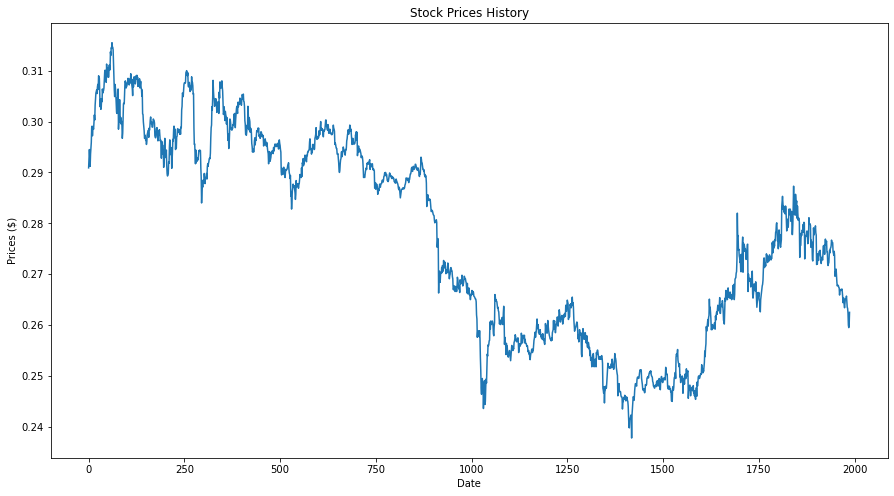

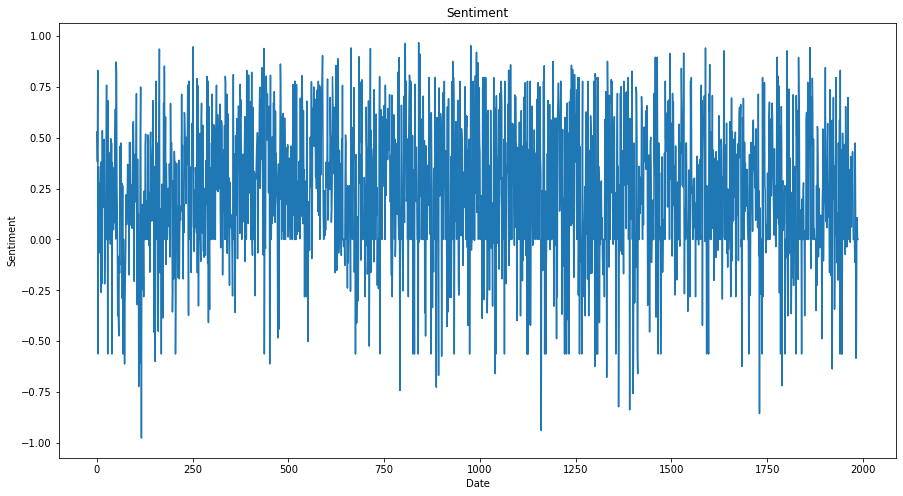

In [130]:
price_data_numeric = pd.to_numeric(pricedata['price'])
sentiment_numeric = pd.to_numeric(tweets['Sentiment'])

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(price_data_numeric)
plt.xlabel('Date')
plt.ylabel('Prices ($)')

plt.figure(figsize=(15, 8))
plt.title('Sentiment')
plt.plot(tweets['Sentiment'])
plt.xlabel('Date')
plt.ylabel('Sentiment')

In [131]:
x_train_sentiment, y_train_sentiment, training_data_len_sentiment, scaled_data_sentiment, scaler = createTrainingData(sentiment_numeric)
x_train_price, y_train_price, training_data_len_price, scaled_data_price, scaler = createTrainingData(price_data_numeric)

x_test_sentiment, y_test_sentiment = createTestData(scaled_data_sentiment, training_data_len_sentiment, sentiment_numeric)
x_test_price, y_test_price = createTestData(scaled_data_price, training_data_len_price, price_data_numeric)

input1 = layers.Input(shape=(x_train_price.shape[1], 1))
input2 = layers.Input(shape=(x_train_sentiment.shape[1], 1))
input = keras.layers.Concatenate()([input1, input2])
lstm_layer1 = layers.LSTM(100, return_sequences=True)(input)
lstm_layer2 = layers.LSTM(100, return_sequences=False)(lstm_layer1)
dense_layer_1 = layers.Dense(25)(lstm_layer2)
output = layers.Dense(1)(dense_layer_1)
model = keras.models.Model(inputs=[input1, input2], outputs=output)

model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 48, 1)]      0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 48, 1)]      0           []                               
                                                                                                  
 concatenate_27 (Concatenate)   (None, 48, 2)        0           ['input_38[0][0]',               
                                                                  'input_39[0][0]']               
                                                                                                  
 lstm_34 (LSTM)                 (None, 48, 100)      41200       ['concatenate_27[0][0]']  

In [132]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([x_train_price, x_train_sentiment], y_train_price, batch_size = 1, epochs=5)

Epoch 1/5
1543/1543 [==============================] - 15s 9ms/step - loss: 0.0033
Epoch 2/5
1543/1543 [==============================] - 13s 9ms/step - loss: 0.0010
Epoch 3/5
1543/1543 [==============================] - 13s 9ms/step - loss: 8.9945e-04
Epoch 4/5
1543/1543 [==============================] - 13s 9ms/step - loss: 7.2098e-04
Epoch 5/5
1543/1543 [==============================] - 13s 9ms/step - loss: 5.7008e-04


In [133]:
predictions = model.predict((x_test_price, x_test_sentiment))
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions[0] - y_test_price)**2)
rmse

13/13 [==============================] - 0s 10ms/step


0.022059864241770602

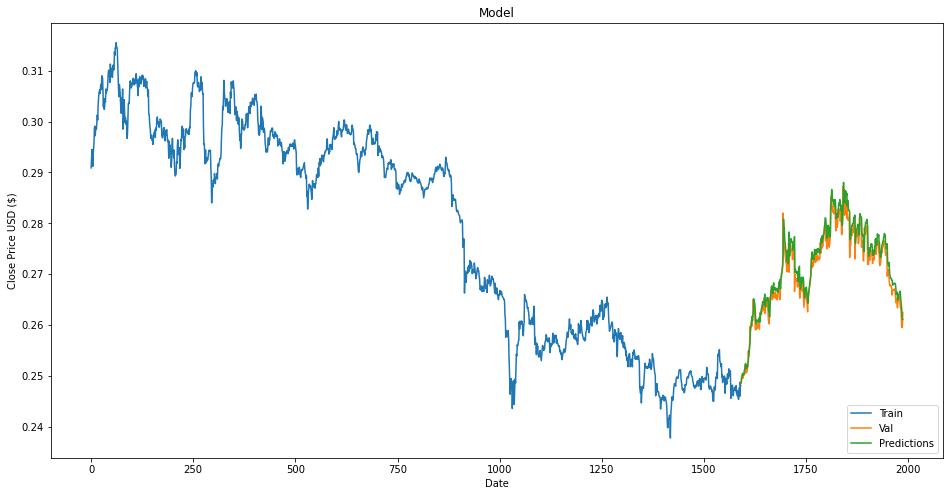

In [134]:
data = price_data_numeric
train = data[:training_data_len_price]

validation = pd.DataFrame()
validation['price'] = data[training_data_len_price:]
validation['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

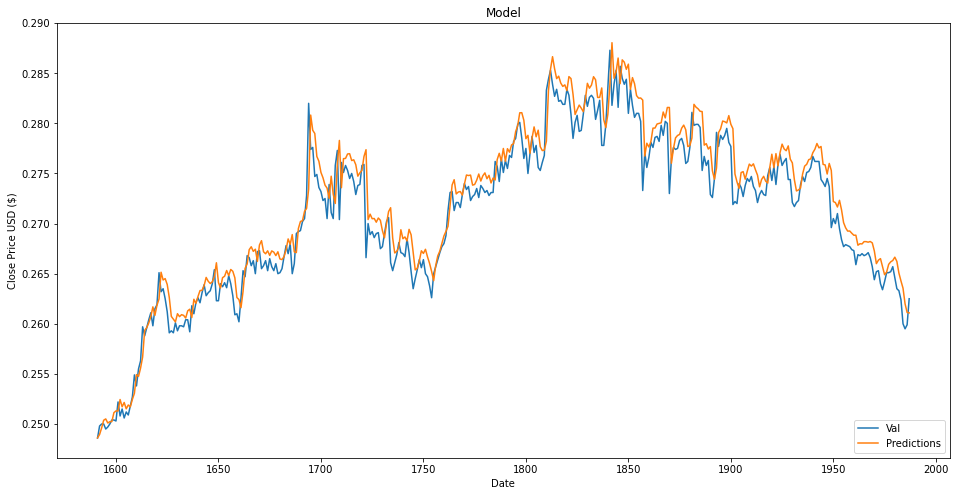

In [135]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()